In [967]:
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer, LSTM, Reshape, TimeDistributed, Dropout, Bidirectional, RepeatVector, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
import gensim.downloader as api

from gensim.models.word2vec import Word2Vec
import pandas as pd
import re
import matplotlib.pyplot as plt
from gensim.test.utils import common_texts, get_tmpfile
from tqdm import tqdm_notebook

# Preprocessing Text

The preprocessing code is data specific.  
  
It is an example of how one can use a pre-trained word2vec to embed sentences into a vector space.

# TODO train w2v model

In [226]:
# corpus = api.load('20-newsgroups')
# info = api.info()  # show info about available models/datasets
# word2vec_model = api.load("glove-twitter-100")  # download the model and return as object ready for use
# word2vec_model.most_similar("cat")

In [1200]:
w2v_model.save("word2vec.model")

In [3]:
w2v_model = Word2Vec.load("word2vec.model")

In [635]:
dataset = pd.read_csv("shortjokes.csv").set_index("ID")

In [636]:
dataset_1 = pd.read_csv("jokes_score_name_clean.csv")

In [637]:
dataset_1["Joke"] = dataset_1["q"] + " " + dataset_1["a"]

In [638]:
dataset_2 = pd.read_csv("qajokes1.1.2.csv")
dataset_2["Joke"] = dataset_2["Question"] + " " + dataset_2["Answer"]

In [639]:
sentences = dataset["Joke"].tolist() + dataset_1["Joke"].tolist() + dataset_2["Joke"].tolist()

In [640]:
def preprocess_text(text):
    return re.sub(
        r"[^\w\s']", 
        "", 
        text
    ).lower().split()

In [641]:
preprocessed_sentences = [preprocess_text(t) for t in sentences]

In [11]:
len(sentences)

440099

In [12]:
# w2v_model = Word2Vec(preprocessed_sentences, size=100, window=10, workers=16, iter=100)
# w2v_model = word2vec_model

In [13]:
w2v_model.wv.most_similar("bolt")

[('phelps', 0.5148839950561523),
 ("bolt's", 0.5110259056091309),
 ('bloodbath', 0.45941269397735596),
 ('gust', 0.4141930341720581),
 ('nada', 0.4051152169704437),
 ('glimpse', 0.40208110213279724),
 ('key', 0.3946117162704468),
 ('ricocheted', 0.39381635189056396),
 ('lightning', 0.38503432273864746),
 ('binos', 0.38127273321151733)]

In [14]:
w2v = w2v_model.wv

Preprocessing text from a variety of different sources.

(array([ 45000., 233729., 105550.,  20059.,   4429.,   2733.,   2216.,
          2010.,   1910.,   1746.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

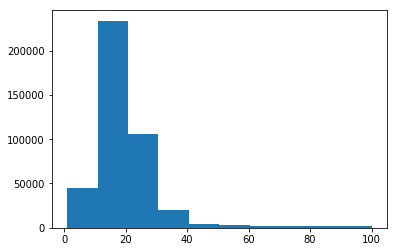

In [632]:
plt.hist([len(s) + 1 for s in preprocessed_sentences if len(s) < 100])

# No LSTM variant

In [642]:
# preprocessed_sentences = [preprocess_text(t) for t in dataset_2["Joke"]]

In [843]:
original_dim = 1000
original_dims = (1000, )

In [844]:
def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return [a for vector in concat_vector for a in vector]

In [1014]:
preprocessed_sentences = [sentence for sentence in preprocessed_sentences if (len(sentence) < 10) & (len(sentence) > 5)]

In [1015]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences]

In [1016]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [1017]:
from keras.preprocessing import sequence
vectorized_padded = sequence.pad_sequences(vectorized_sentences, maxlen=original_dim, padding="post", truncating="post")

In [1018]:
# normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())# + 0.01*np.random.randn(*normalized_vectorized_padded.shape)
normalized_vectorized_padded = vectorized_padded

In [1019]:
weights_masks = np.array([[1.] * (len(sentence) * 100) + [0] * (original_dim - len(sentence) * 100) for sentence in tqdm_notebook(preprocessed_sentences)])

# LSTM variant

In [313]:
preprocessed_sentences = [preprocess_text(t) for t in dataset_2["Joke"]]

In [322]:
def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return concat_vector

In [323]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 20) & (len(sentence) > 10)]

In [324]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [325]:
vectorized_padded = np.array([sentence + [[0] * 100] * (20 - len(sentence)) for sentence in vectorized_sentences])

In [328]:
normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())

In [329]:
original_dims = (20, 100)
original_dim = 2000

It's important to shuffle the text vectors before splitting them into test and train samples.   
  
This is done to avoid clumping text with similar context and style in the dataset because it can confuse the neural network during training.

In [1020]:
from sklearn.model_selection import ShuffleSplit

In [1021]:
split = ShuffleSplit(n_splits=3)
train_indices, test_indices = next(split.split(normalized_vectorized_padded))

In [1022]:
vectorized_train = normalized_vectorized_padded[train_indices]
vectorized_test = normalized_vectorized_padded[test_indices]

In [1023]:
train_weights_masks = weights_masks[train_indices]
test_weights_masks = weights_masks[test_indices]

In [1024]:
batch_size = 500
def cut_dataset(dataset, batch_size):
    rest = len(dataset) % batch_size
    return dataset[:-rest]

vectorized_train = cut_dataset(vectorized_train, batch_size)
vectorized_test = cut_dataset(vectorized_test, batch_size)
train_weights_masks = cut_dataset(train_weights_masks, batch_size)
test_weights_masks = cut_dataset(test_weights_masks, batch_size)

In [1025]:
help_vectorized_train = vectorized_train.reshape(-1, original_dim)
help_vectorized_test = vectorized_test.reshape(-1, original_dim)

Get w2v embeddings for text with fixed length

# Variational Autoencoder

1. Values are normalized for sigmoid - done
2. LSTM usage in encoder - done
3. LSTM usage in decoder - done (without Flatten - not done)
4. Layers dropout - not done, underfitting
5. Tokens instead of word2vec vectors? Or use something instead of binary crossentropy?

Binary crossentropy for non binary values?!

Use something that can replace E[log P(X|z)]

Why cross-entropy?

In [1026]:
from keras import callbacks

In [1027]:
latent_dim = 100
lstm_dim = 100
intermediate_dim = 1000
epochs = 200
epsilon_std = 1.

In [1028]:
x = Input(shape=original_dims)
weights_mask = Input(shape=original_dims)
h = Dropout(0.2)(x)
h = Dense(intermediate_dim, activation='relu')(h)
h_mean = Dense(intermediate_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h_mean)
h_log_var = Dense(intermediate_dim, activation='relu')(h)
z_log_var = Dense(latent_dim)(h_log_var)

In [1029]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [1030]:
# we instantiate these layers separately so as to reuse them later
decoder_h_1 = Dense(intermediate_dim, activation='relu')
decoder_h_2 = Dense(intermediate_dim, activation='relu')
decoder_h_3 = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='linear') 

h_decoded = decoder_h_1(z)
h_decoded = decoder_h_2(h_decoded)
h_decoded = decoder_h_3(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

In [1031]:
# def xent_loss(y_true, y_pred):
# #     return K.sum(K.binary_crossentropy(y_true, y_pred), axis=1)
#     return original_dim * K.binary_crossentropy(y_true, y_pred)

# def kl_loss(y_true, y_pred):
# #     return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var, axis=1)
#     return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# def vae_loss(y_true, y_pred):
# #     return xent_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
#     return K.mean(xent_loss(y_true, y_pred) + kl_loss(y_true, y_pred))

def vae_loss(x, x_decoded_mean):
#     xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    xent_loss = original_dim * metrics.mean_squared_error(x * weights_mask, x_decoded_mean * weights_mask)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [1035]:
vae = Model([x, weights_mask], x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss, metrics=["mse", "accuracy"])

In [1033]:
# vae.predict(vectorized_train, batch_size=batch_size) - vectorized_train

In [1036]:
#### checkpoint
cp = [callbacks.ModelCheckpoint(filepath="/tmp/model.h5", verbose=1)]

#train
vae.fit([vectorized_train, train_weights_masks], help_vectorized_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([vectorized_test, test_weights_masks], help_vectorized_test),
        callbacks=cp)

Train on 28000 samples, validate on 3000 samples
Epoch 1/200
28000/28000 [==============================] - 15s 520us/step - loss: 2007.6319 - mean_squared_error: 2.2629 - acc: 0.5499 - val_loss: 1900.9103 - val_mean_squared_error: 2.1582 - val_acc: 0.5817

Epoch 00001: saving model to /tmp/model.h5
Epoch 2/200
28000/28000 [==============================] - 5s 173us/step - loss: 1764.2944 - mean_squared_error: 2.0408 - acc: 0.5826 - val_loss: 1880.3573 - val_mean_squared_error: 2.1503 - val_acc: 0.5833

Epoch 00002: saving model to /tmp/model.h5
Epoch 3/200
28000/28000 [==============================] - 5s 175us/step - loss: 1754.2659 - mean_squared_error: 2.0341 - acc: 0.5814 - val_loss: 1875.4743 - val_mean_squared_error: 2.1430 - val_acc: 0.5847

Epoch 00003: saving model to /tmp/model.h5
Epoch 4/200
28000/28000 [==============================] - 5s 176us/step - loss: 1750.4319 - mean_squared_error: 2.0306 - acc: 0.5838 - val_loss: 1875.0781 - val_mean_squared_error: 2.1417 - val_ac

KeyboardInterrupt: 

In [1081]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

def weighted(y):
    return y * weights_mask

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=( latent_dim,))
_h_decoded = decoder_h_1(decoder_input)
_h_decoded = decoder_h_2(_h_decoded)
_h_decoded = decoder_h_3(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = Lambda(weighted, output_shape=(original_dim,))(_x_decoded_mean)
generator = Model([decoder_input, weights_mask], _x_decoded_mean)

In [1082]:
test_model = Model(x, z_mean)
np.min(test_model.predict(vectorized_test[0:10])), np.max(test_model.predict(vectorized_test[0:10]))

(-3.3315232, 3.1993313)

# Generating Text From Latent Space

In [1083]:
# some matrix magic
def sent_parse(sentence, mat_shape):
    data_concat = []
    word_vecs = vectorize_sentences(sentence)
    for x in word_vecs:
        data_concat.append(list(itertools.chain.from_iterable(x)))
    zero_matr = np.zeros(mat_shape)
    zero_matr[0] = np.array(data_concat)
    return zero_matr

In [1084]:
def print_sentence_with_w2v(sent_vect):
#     sent_vect = sent_vect * (vectorized_padded.max() - vectorized_padded.min()) + vectorized_padded.min()
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/100)):
        word_sent += w2v.most_similar(positive=[tocut[:100]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[100:]
    print(word_sent)

In [1085]:
# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

In [1086]:
# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

In [1087]:
# input: two written sentences, VAE batch-size, dimension of VAE input
# output: the function embeds the sentences in latent-space, and then prints their generated text representations
# along with the text representations of several points in between them
def sent_2_sent(sent1,sent2, batch, dim):
    a = sent_parse([sent1], (batch,dim))
    b = sent_parse([sent2], (batch,dim))
    encode_a = encoder.predict(a, batch_size = batch)
    encode_b = encoder.predict(b, batch_size = batch)
    test_hom = hom_shortest(encode_a[0], encode_b[0], 5)
    
    for point in test_hom:
        p = generator.predict(np.array([point]))[0]
        print_sentence(p)

Printing sentences from the training set and comparing them with the original will test whether the custom print function works properly.

In [1090]:
# sentences = [vectorize_sentence(preprocess_text("who are you to be here"))]
# padded_sentences = sequence.pad_sequences(sentences, maxlen=original_dim, padding="post", truncating="post")
padded_sentences = vectorized_test[0:50]

The encoder takes the training set of sentence vectors (concatenanted word vectors) and embeds them into a lower dimensional vector space.

In [1091]:
sent_encoded = encoder.predict(padded_sentences)

In [1092]:
sent_encoded.shape

(50, 100)

The decoder takes the list of latent dimensional encodings from above and turns them back into vectors of their original dimension.

In [1093]:
sent_decoded = generator.predict([sent_encoded, test_weights_masks[0:50]])

In [1095]:
for i, sentence in enumerate(sent_decoded):
    print("Original...")
    print_sentence_with_w2v(padded_sentences[i])
    print("Generated...")
    print_sentence_with_w2v(sentence)
    print("===========================")

Original...
what do you call a gay tramp hobosexual the the 
Generated...
what do you call a gay dinosaur a snowblower the 
Original...
why don't lobsters like to share they're shellfish the the 
Generated...
why don't men like to share they're shellfish shellfish the 
Original...
what do you call a poor stripper ugly the the 
Generated...
what do you call a fat woman ugly brothel the 
Original...
how to keep a reader in suspense removed the the 
Generated...
how to keep a reader in it selected the the 
Original...
i put the p in pants the the the the 
Generated...
i put the it in nose the the the the 
Original...
what is et short for he's got little legs the 
Generated...
what is et short for he's the the the the 
Original...
what did silver say to gold au the the the 
Generated...
what did 0 say to stripes waiter the the the 
Original...
what borders obesity mexico and canada the the the the 
Generated...
what trump economic canada the mexico canada shipping the the 
Original...
so i